<a href="https://colab.research.google.com/github/Ramyaramz2004/rfm-analysis/blob/main/rfm_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing Required python Libraries
-**pandas for data manipulation,**

-**numpy for numerical operations,**

matplotlib.pyplot and seaborn for data visualization,
datetime and timedelta for date/time calculations,
sklearn for building and evaluating a machine learning model (Random Forest).
classification_report
Provides a full summary of:Precision,Recall,F1-Score,Support
confusion_matrix
Shows a matrix layout of actual vs. predicted segments.
Helps visualize which segments the model confuses most often.
Useful for understanding misclassification.
accuracy_score
Returns the overall accuracy:

These libraries are widely used in data science projects for efficient data processing and visualization.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime,timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score


### Loading the Dataset
 Here We load the Excel file that contains details of:
Customer ID,Purchase Date, Order ID, Transaction Amount
We use a 'try-except' block to handle cases where the file might not be found, ensuring the code does not crash abruptly.


In [ ]:
try:
   df=pd.read_excel("/content/product rfm analysis data.xlsx")
except FileNotFoundError:
    print(f"Error: The file {file_path} was not found. Please ensure the file exists in the correct directory.")
    exit()

### Converting 'PurchaseDate' to proper datetime format for time-based analysis.
If it’s stored as Excel serial numbers, we transform it accordingly.
If we didn't change the purchase date to proper datetime format we can't get the proper output

In [ ]:
if not pd.api.types.is_datetime64_any_dtype(df['PurchaseDate']):
    try:
        df['PurchaseDate'] = pd.to_timedelta(df['PurchaseDate'], unit='d') + pd.Timestamp('1899-12-30')
    except:
        print("Error: PurchaseDate column is not in a recognizable date format.")
        exit()
else:
    df['PurchaseDate'] = pd.to_datetime(df['PurchaseDate'])

### Cleaning the dataset:
 In this process we will be Removing rows with missing critical data (CustomerID, PurchaseDate, TransactionAmount).
Creating a numeric column for 'TransactionAmount' to ensure it can be used for calculations.
Here we will fill the missing values and remove the duplicates using dropna.


In [ ]:
df['TransformationAmount']=pd.to_numeric(df['TransactionAmount'],errors='coerce')
df=df.dropna(subset=['CustomerID','PurchaseDate','TransactionAmount'])

### Creating the RFM table:
*Recency*: How recently a customer made a purchase.

*Frequency*: How many purchases the customer made frequently.

*Monetary*: Total amount spent by the customer on the product.

These are grouped by CustomerID and calculated relative to the most recent transaction date in the dataset.


In [ ]:
analysis_date=df['PurchaseDate'].max()+timedelta(days=1)
rfm=df.groupby('CustomerID').agg({'PurchaseDate':lambda x:(analysis_date-x.max()).days,
                                  'OrderID':'count',
                                  'TransactionAmount':'sum'}).reset_index()
rfm.columns=['CustomerID','Recency','Frequency','Monetary']

###RFM Scoring using quintiles
###We divide Recency, Frequency, and Monetary into 5 quantiles and assign scores from 1 to 5.
###Lower Recency is better, so we reverse the scoring labels.
###We assign R, F, and M scores from 1 (low) to 5 (high).
###For Frequency, we want to score customers based on how often they made purchases.
###Customers with more orders are considered more engaged.
###For Monetary value, we assign higher scores to higher spenders using quantile bins.
###We then combine all three scores into a single string to form the RFM segment identifier.
## qcut
###For example, with 5 quantiles, each bin will have approximately 20% of the data.
### Labels allow us to assign meaningful numerical scores to these quantiles (e.g., 1 to 5).
###This is especially useful for Recency, Frequency, and Monetary value segmentation.

In [ ]:
rfm['R_Score']=pd.qcut(rfm['Recency'],5,labels=[5,4,3,2,1],duplicates='drop')
rfm['F_Score']=pd.qcut(rfm['Frequency'].rank(method='first'),5,labels=[1,2,3,4,5])
rfm['M_Score']=pd.qcut(rfm['Monetary'],5,labels=[1,2,3,4,5],duplicates='drop')
rfm['RFM_Score']=rfm['R_Score'].astype(str)+rfm['F_Score'].astype(str)+rfm['M_Score'].astype(str)

###  Segmenting Customers Based on RFM Scores
Customers are categorized into five segments using logical rules:

*High-Value*: Recent, frequent, and high spenders.

*Loyal*: Frequent and fairly recent buyers.

*Big Spenders*: Customers who spend a lot.

*At Risk*: Infrequent and inactive customers.

*Other*: Everyone else not fitting the above.

we are using this segmentation to target specific customer groups effectively.


In [ ]:
def segment_customer(row):
    if row['R_Score'] >=4 and row['F_Score'] >= 4 and row['M_Score'] >=4:
        return 'High-Value'
    elif row['R_Score'] >=3 and row['F_Score'] >=3:
        return 'Loyal'
    elif row['R_Score'] >=3 and row['M_Score'] >=3:
        return 'Big Spender'
    elif row['R_Score'] <=2 and row['F_Score'] <=2:
        return 'At Risk'
    else:
        return 'Other'
rfm['Segment']=rfm.apply(segment_customer,axis=1)

###  Building a Machine Learning Model

We use a *Random Forest Classifier**to learn from the RFM scores and predict customer segments more accurant:

The model is trained on 80% of the data.

20% of the data is reserved for testing (evaluation).

This helps automate segmentation for future customers based on their RFM scores.


In [ ]:
x=rfm[['R_Score','F_Score','M_Score']].astype(int)
y=rfm['Segment']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)

###Evaluating Model Performance

- **Classification Report**: Precision, recall, F1-score.
- **Accuracy Score**: Overall correctness.

A **confusion matrix** is plotted to visualize how well the model distinguishes between customer segments like loyal,highrisk and others


In [ ]:
clf=RandomForestClassifier(random_state=41)
clf.fit(x_train,y_train)
y_pred=clf.predict(x_test)

###Visualizing Customer Segment Distribution:

A bar plot is used to show how many customers belong to each segment.

We:
- Apply different colors for each segment.
- evaluate each bar with the exact count.
- Rotate labels for better readability.

This helps us to analyse which types of customers are most common.


In [ ]:
try:
    print("\nModel Performance on Test Set:")
    print(classification_report(y_test, y_pred))
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nAccuracy Score: {accuracy:.4f}")
except Exception as e:
    print(f"Error in model evaluation: {e}")
    exit()


Model Performance on Test Set:
              precision    recall  f1-score   support

     At Risk       1.00      1.00      1.00       180
 Big Spender       1.00      1.00      1.00         8
  High-Value       1.00      1.00      1.00        80
       Loyal       1.00      1.00      1.00       196
       Other       1.00      1.00      1.00        19

    accuracy                           1.00       483
   macro avg       1.00      1.00      1.00       483
weighted avg       1.00      1.00      1.00       483


Accuracy Score: 1.0000


### Exploring Distribution of RFM Values
Three histograms are plotted based on
- **Recency**
- **Frequency**
- **Monetary**

We use different colors and annotate each bar with the count. This shows how customer behavior varies across the dataset.


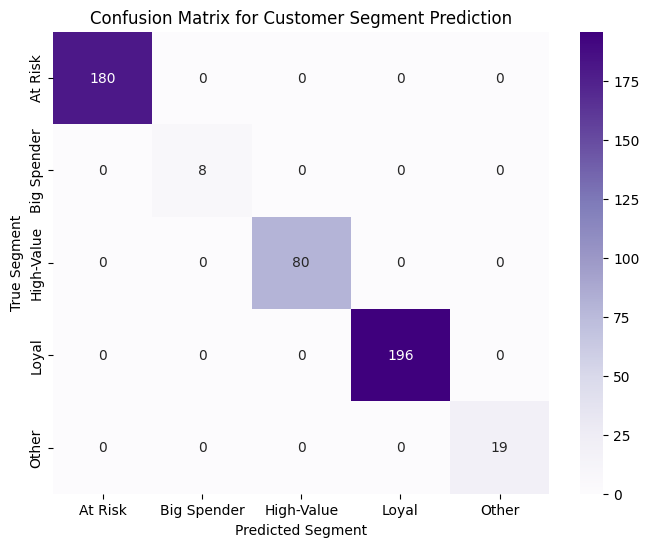

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.title('Confusion Matrix for Customer Segment Prediction')
plt.xlabel('Predicted Segment')
plt.ylabel('True Segment')
plt.savefig('confusion_matrix.png')
plt.show()

###Segment Distribution

This step prints the RFM analysis summary, including individual customer scores and segment labels. It also displays how customers are distributed across segments in the full dataset, and separately in the training and test sets. This helps us understand the class balance and whether the data is representative for modeling.




In [ ]:
print("RFM Analysis Summary:")
print(rfm[['CustomerID','Recency','Frequency','Monetary','R_Score','F_Score','M_Score','Segment']])
print("\nSegment Distribution in Full Dataset:")
print(rfm['Segment'].value_counts())
print("\nSegment Distribution in Training Set:")
print(y_train.value_counts())
print("\nSegment Distribution in Test Set;")
print(y_test.value_counts())

RFM Analysis Summary:
      CustomerID  Recency  Frequency  Monetary R_Score F_Score M_Score  \
0           1011      798          2   1129.02       1       5       5   
1           1025      786          1    359.29       2       1       2   
2           1029      765          1    704.99       2       1       4   
3           1046      808          1    859.82       1       1       4   
4           1049      778          1    225.72       2       1       1   
...          ...      ...        ...       ...     ...     ...     ...   
2408       12982      162          3   1873.24       5       5       5   
2409       12985      537          1    483.96       3       5       2   
2410       12987      157          2    927.20       5       5       5   
2411       12988      470          1    242.46       3       5       1   
2412       12991        1          3   1648.29       5       5       5   

         Segment  
0          Other  
1        At Risk  
2        At Risk  
3        At R

###Visualize Segment Distribution
In this step, we use a count plot to visualize how customers are distributed across different segments. Each bar represents the number of customers in a specific segment (e.g., High-Value, At Risk, other). Custom colors are used to make the segments more visually distinct and easier to interpret.



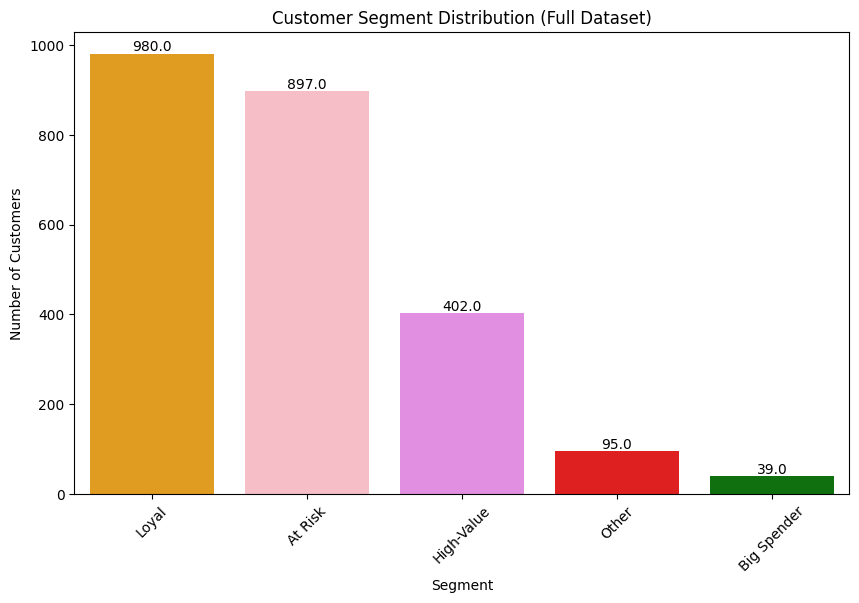

In [ ]:
plt.figure(figsize=(10, 6))
segment_counts = rfm['Segment'].value_counts()
colors = ['red', 'lightpink', 'green', 'violet', 'orange']
ax = sns.countplot(
    data=rfm,
    x='Segment',
    hue='Segment',
    order=segment_counts.index,
    palette=colors,
    legend=False
)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom')
plt.title('Customer Segment Distribution (Full Dataset)')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.savefig('segment_distribution_full.png')
plt.show()

###Histograms for RFM
here we displays histograms for Recency, Frequency, and Monetary values. These plots help understand the distribution of each RFM metric in the dataset. It shows how recently customers purchased, how frequently they buy, and how much they typically spend.

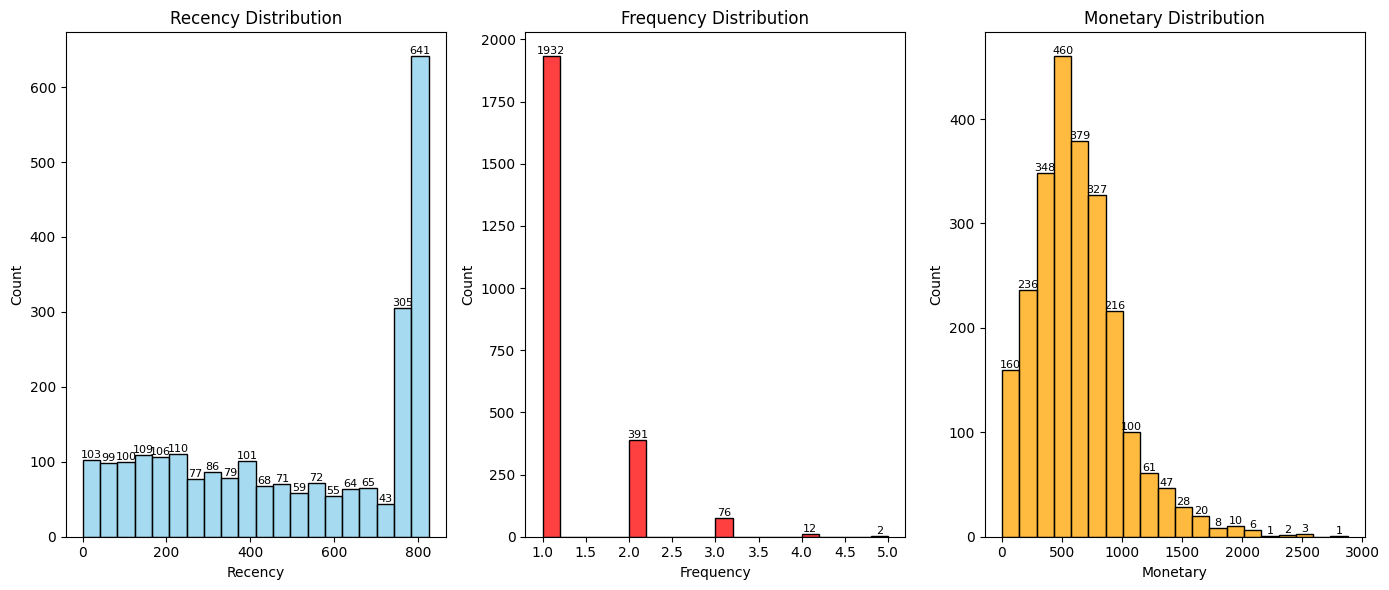

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(14, 6))

# Recency Histogram
sns.histplot(rfm['Recency'], bins=20, ax=axes[0], color='skyblue')
axes[0].set_title('Recency Distribution')
for p in axes[0].patches:
    if p.get_height() > 0:
        axes[0].annotate(int(p.get_height()),
                         (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='bottom', fontsize=8)

# Frequency Histogram
sns.histplot(rfm['Frequency'], bins=20, ax=axes[1], color='red')
axes[1].set_title('Frequency Distribution')
for p in axes[1].patches:
    if p.get_height() > 0:
        axes[1].annotate(int(p.get_height()),
                         (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='bottom', fontsize=8)

# Monetary Histogram
sns.histplot(rfm['Monetary'], bins=20, ax=axes[2], color='orange')
axes[2].set_title('Monetary Distribution')
for p in axes[2].patches:
    if p.get_height() > 0:
        axes[2].annotate(int(p.get_height()),
                         (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('rfm_distributions.png')
plt.show()


###Scatter Plot - *Recency vs Monetary*
Finally, we create a scatter plot to analyze the relationship between Recency and Monetary value, with each point representing a customer. Customers are color-coded and styled by their segment, and the size of each point indicates Frequency. This helps us visually differentiate behavior patterns across segments.

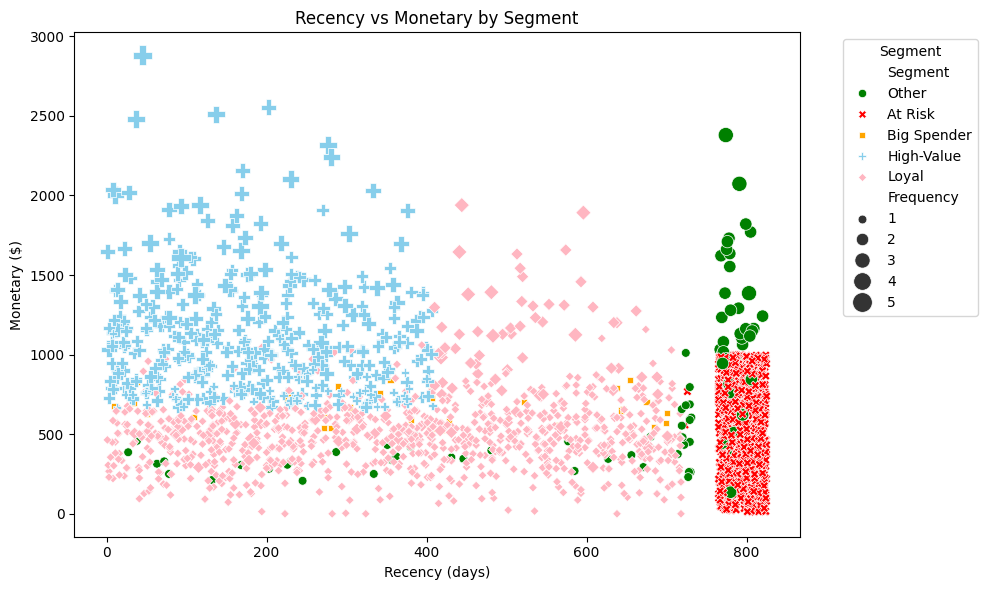

In [ ]:
palette = {
    'High-Value': 'skyblue',
    'Loyal': 'lightpink',
    'Big Spender': 'orange',
    'At Risk': 'red',
    'Other': 'green'
}
# Custom color palette for segments
palette = {
    'High-Value': 'skyblue',
    'Loyal': 'lightpink',
    'Big Spender': 'orange',
    'At Risk': 'red',
    'Other': 'green'
}

# Scatter plot with colored segments
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary',
                hue='Segment', style='Segment', size='Frequency',
                palette=palette, sizes=(40, 200))
plt.title('Recency vs Monetary by Segment')
plt.xlabel('Recency (days)')
plt.ylabel('Monetary ($)')
plt.legend(title='Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('recency_monetary_scatter.png')
plt.show()



###CONCLUSION

This project demonstrates how to:
- Preprocess transactional data.
- Apply RFM analysis.
- Segment customers using logic and machine learning.
- Visualize results to support business decision-making.

This approach is practical for retail, e-commerce, or any customer-focused business.
